In [1]:
using Lux, Reactant, Random, Optimisers, Enzyme, Statistics, JLD2, Plots

const cdev = cpu_device()
const xdev = reactant_device(; force=true);

In [2]:
const L = 10.0f0
const t_end = 30.0f0
ν = 0.1f0

const u_mean = 1.0f0
const u_amplitude = 0.5f0
const k = 2.0f0*pi/L
u0(x) = Float32(u_mean + u_amplitude * cos(k*x));

λ_pde = 1.0f0
λ_ic = 0.05f0
λ_bc = 0.1f0;

In [3]:
struct PINN{M} <: AbstractLuxWrapperLayer{:model}
    model::M
end

function PINN(; hidden_dims::Int=64)
    return PINN(
        Chain(
            Dense(2 => hidden_dims, tanh),
            Dense(hidden_dims => hidden_dims, tanh),
            Dense(hidden_dims => hidden_dims, tanh),
            Dense(hidden_dims => hidden_dims, tanh),
            Dense(hidden_dims => 1),
        ),
    )
end;

In [4]:
function u(model::StatefulLuxLayer, xt::AbstractArray)
    return model(xt)
end

function ∂u_∂t(model::StatefulLuxLayer, xt::AbstractArray)
    return Enzyme.gradient(Enzyme.Reverse, sum ∘ model, xt)[1][2, :]
end

function ∂u_∂x(model::StatefulLuxLayer, xt::AbstractArray)
    return Enzyme.gradient(Enzyme.Reverse, sum ∘ model, xt)[1][1, :]
end
function ∂²u_∂x²(model::StatefulLuxLayer, xt::AbstractArray)
    return Enzyme.gradient(Enzyme.Reverse, sum ∘ ∂u_∂x, Enzyme.Const(model), xt)[2][1, :]
end;

In [5]:
function physics_informed_loss_function(model::StatefulLuxLayer, xt::AbstractArray)
    return mean(abs2, ∂u_∂t(model, xt) .+ (u(model, xt) .* ∂u_∂x(model, xt)) .- (ν .* ∂²u_∂x²(model, xt)))
end
function bc_loss_function(model::StatefulLuxLayer, xt_i::AbstractArray, xt_f::AbstractArray)
    u_i = model(xt_i)
    u_f = model(xt_f)
    mean(abs2, u_i .- u_f)
end
function ic_loss_function(model::StatefulLuxLayer, xt::AbstractArray, target::AbstractArray)
    u = model(xt)
    mean(abs2, u .- target)
end
function loss_function(model, ps, st, (xt, xt_bc_i, xt_bc_f, xt_ic, target_ic))
    smodel = StatefulLuxLayer(model, ps, st)
    physics_loss = physics_informed_loss_function(smodel, xt)
    bc_loss = bc_loss_function(smodel, xt_bc_i, xt_bc_f)
    ic_loss = ic_loss_function(smodel, xt_ic, target_ic)
    loss = λ_pde * physics_loss + λ_bc * bc_loss + λ_ic * ic_loss
    return loss, smodel.st, (; physics_loss, bc_loss, ic_loss, total_loss=loss)
end;

In [6]:
function get_data(rng, batch_size_pde, batch_size_bc, batch_size_ic; current_segment=1, total_segments=10)
    xt = rand(rng, Float32, (2, batch_size_pde))
    xt[1, :] .*= L
    xt[2, :] .*= (t_end*current_segment/total_segments)

    rand_t_bc = rand(rng, Float32, batch_size_bc) .* (t_end*current_segment/total_segments)
    xt_bc_i = zeros(Float32, (2, batch_size_bc))
    xt_bc_i[2, :] = rand_t_bc

    xt_bc_f = fill(L, (2, batch_size_bc))
    xt_bc_f[2, :] = rand_t_bc
    

    rand_x_ic = rand(rng, Float32, batch_size_ic) .* L
    xt_ic = zeros(Float32, (2, batch_size_ic))
    xt_ic[1, :] = rand_x_ic

    target_ic = reshape(u0.(rand_x_ic), 1, :)
    return (xt, xt_bc_i, xt_bc_f, xt_ic, target_ic)
end;

In [7]:
function train_model(; seed::Int=0, maxiters::Int=10000, hidden_dims::Int=64, 
        batch_size_pde::Int=256, batch_size_bc::Int=64, batch_size_ic::Int=64, total_segments::Int=10)
    
    rng = Random.default_rng()
    Random.seed!(rng, seed)

    pinn = PINN(; hidden_dims)
    ps, st = Lux.setup(rng, pinn) |> xdev

    train_state = Training.TrainState(pinn, ps, st, AdamW(0.0005f0))

    lr = i -> i < 5000 ? 0.0005f0 : (i < 10000 ? 0.00005f0 : 0.000005f0)
    
    total_losses = Float32[]
    physics_losses = Float32[]
    bc_losses = Float32[]
    ic_losses = Float32[]

    for iter in 1:maxiters
        current_segment = ((iter * total_segments) ÷ maxiters) + 1
        
        batch = get_data(rng, batch_size_pde, batch_size_bc, batch_size_ic; current_segment, total_segments) |> xdev
        
        Optimisers.adjust!(train_state, lr(iter))

        _, loss, stats, train_state = Training.single_train_step!(AutoEnzyme(),
                                                              loss_function,
                                                              batch,
                                                              train_state;
                                                              return_gradients=Val(false),
        )
        
        if iter % 1000 == 0   
            push!(total_losses, Float32(stats.total_loss))
            push!(physics_losses, Float32(stats.physics_loss))
            push!(bc_losses, Float32(stats.bc_loss))
            push!(ic_losses, Float32(stats.ic_loss))
        end

        if iter % 1000 == 0
            println("Iter: $(iter), loss: $(Float32(loss))")
        end
    end

    return StatefulLuxLayer(pinn, cdev(train_state.parameters), cdev(train_state.states)), (; physics_losses, bc_losses, ic_losses, total_losses)
end;

In [8]:
batch_size_pde = 512
batch_size_bc = 16
batch_size_ic = 16
total_segments = 100
maxiters = 1000000
trained_model, losses = train_model(; maxiters, batch_size_pde, batch_size_bc, batch_size_ic, total_segments);

Iter: 1000, loss: 0.003469761


I0000 00:00:1757364213.454342    6474 service.cc:163] XLA service 0x3d4534c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757364213.454366    6474 service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
I0000 00:00:1757364213.454883    6474 se_gpu_pjrt_client.cc:1338] Using BFC allocator.
I0000 00:00:1757364213.454925    6474 gpu_helpers.cc:136] XLA backend allocating 6159925248 bytes on device 0 for BFCAllocator.
I0000 00:00:1757364213.454962    6474 gpu_helpers.cc:177] XLA backend will use up to 2053308416 bytes on device 0 for CollectiveBFCAllocator.
I0000 00:00:1757364213.467300    6474 cuda_dnn.cc:463] Loaded cuDNN version 90800


Iter: 2000, loss: 0.002307942
Iter: 3000, loss: 0.0018732087
Iter: 4000, loss: 0.002422973
Iter: 5000, loss: 0.0019918075
Iter: 6000, loss: 0.0020161413
Iter: 7000, loss: 0.0015846794
Iter: 8000, loss: 0.0015931369
Iter: 9000, loss: 0.001815202
Iter: 10000, loss: 0.00308584
Iter: 11000, loss: 0.0017912679
Iter: 12000, loss: 0.001636224
Iter: 13000, loss: 0.0014027643
Iter: 14000, loss: 0.0019695265
Iter: 15000, loss: 0.0019308019
Iter: 16000, loss: 0.0017983434
Iter: 17000, loss: 0.0018129958
Iter: 18000, loss: 0.0020374286
Iter: 19000, loss: 0.0018431356
Iter: 20000, loss: 0.0027688374
Iter: 21000, loss: 0.0015033307
Iter: 22000, loss: 0.0016570473
Iter: 23000, loss: 0.0019671568
Iter: 24000, loss: 0.0013554652
Iter: 25000, loss: 0.001891813
Iter: 26000, loss: 0.0016450695
Iter: 27000, loss: 0.0022853662
Iter: 28000, loss: 0.001772346
Iter: 29000, loss: 0.0019493466
Iter: 30000, loss: 0.0019228782
Iter: 31000, loss: 0.0018602166
Iter: 32000, loss: 0.0017165169
Iter: 33000, loss: 0.001

Iter: 254000, loss: 0.0008651643
Iter: 255000, loss: 0.00082709634
Iter: 256000, loss: 0.0009896368
Iter: 257000, loss: 0.00083665655
Iter: 258000, loss: 0.00078775076
Iter: 259000, loss: 0.0008384225
Iter: 260000, loss: 0.0009121597
Iter: 261000, loss: 0.0009184439
Iter: 262000, loss: 0.0010044202
Iter: 263000, loss: 0.000904741
Iter: 264000, loss: 0.0007842211
Iter: 265000, loss: 0.0008792486
Iter: 266000, loss: 0.0008139739
Iter: 267000, loss: 0.0009445661
Iter: 268000, loss: 0.00088869885
Iter: 269000, loss: 0.00085500913
Iter: 270000, loss: 0.0008845265
Iter: 271000, loss: 0.0008848746
Iter: 272000, loss: 0.0008176013
Iter: 273000, loss: 0.00079226075
Iter: 274000, loss: 0.00084371073
Iter: 275000, loss: 0.00089879613
Iter: 276000, loss: 0.00094902434
Iter: 277000, loss: 0.0009121245
Iter: 278000, loss: 0.00090890744
Iter: 279000, loss: 0.0007723978
Iter: 280000, loss: 0.0008612409
Iter: 281000, loss: 0.0008310324
Iter: 282000, loss: 0.0008604474
Iter: 283000, loss: 0.00090342376


Iter: 500000, loss: 0.0005681971
Iter: 501000, loss: 0.0004626991
Iter: 502000, loss: 0.0004286605
Iter: 503000, loss: 0.00043770837
Iter: 504000, loss: 0.0004994448
Iter: 505000, loss: 0.00048362758
Iter: 506000, loss: 0.00047943226
Iter: 507000, loss: 0.00046530637
Iter: 508000, loss: 0.00037558464
Iter: 509000, loss: 0.00039028763
Iter: 510000, loss: 0.00047215098
Iter: 511000, loss: 0.0004420857
Iter: 512000, loss: 0.00047935595
Iter: 513000, loss: 0.0004739578
Iter: 514000, loss: 0.00035846353
Iter: 515000, loss: 0.00044106835
Iter: 516000, loss: 0.0005007447
Iter: 517000, loss: 0.00046481675
Iter: 518000, loss: 0.0004242931
Iter: 519000, loss: 0.00043919325
Iter: 520000, loss: 0.00044866395
Iter: 521000, loss: 0.00041801785
Iter: 522000, loss: 0.00047661675
Iter: 523000, loss: 0.0004453867
Iter: 524000, loss: 0.00040970175
Iter: 525000, loss: 0.00043602524
Iter: 526000, loss: 0.00038944048
Iter: 527000, loss: 0.00043372356
Iter: 528000, loss: 0.000404796
Iter: 529000, loss: 0.000

Iter: 744000, loss: 0.0003176704
Iter: 745000, loss: 0.00036656146
Iter: 746000, loss: 0.00029564797
Iter: 747000, loss: 0.00029818347
Iter: 748000, loss: 0.0002950374
Iter: 749000, loss: 0.00027550128
Iter: 750000, loss: 0.00028933707
Iter: 751000, loss: 0.00022885462
Iter: 752000, loss: 0.00031924454
Iter: 753000, loss: 0.00027640117
Iter: 754000, loss: 0.00031974242
Iter: 755000, loss: 0.00031254132
Iter: 756000, loss: 0.0002837326
Iter: 757000, loss: 0.00025272617
Iter: 758000, loss: 0.00029183854
Iter: 759000, loss: 0.00032246666
Iter: 760000, loss: 0.00029873618
Iter: 761000, loss: 0.00029954754
Iter: 762000, loss: 0.00028860502
Iter: 763000, loss: 0.0002812683
Iter: 764000, loss: 0.00028050036
Iter: 765000, loss: 0.00028710606
Iter: 766000, loss: 0.00033452743
Iter: 767000, loss: 0.00023669477
Iter: 768000, loss: 0.00030813142
Iter: 769000, loss: 0.00031386962
Iter: 770000, loss: 0.00028717937
Iter: 771000, loss: 0.0003070363
Iter: 772000, loss: 0.0003509641
Iter: 773000, loss: 

Iter: 987000, loss: 0.00022378743
Iter: 988000, loss: 0.00021571628
Iter: 989000, loss: 0.00021526113
Iter: 990000, loss: 0.00023012556
Iter: 991000, loss: 0.00020784729
Iter: 992000, loss: 0.0002137318
Iter: 993000, loss: 0.00021959376
Iter: 994000, loss: 0.00021606746
Iter: 995000, loss: 0.00021777717
Iter: 996000, loss: 0.00023786974
Iter: 997000, loss: 0.00023259487
Iter: 998000, loss: 0.0002249162
Iter: 999000, loss: 0.00021215524
Iter: 1000000, loss: 0.0001733753


In [9]:
data=load("burgers1d_periodic.jld2")

t_grid = Float32.(data["times"])
x_grid = Float32.(collect(data["grid"]))
u_target = data["solution"]; 

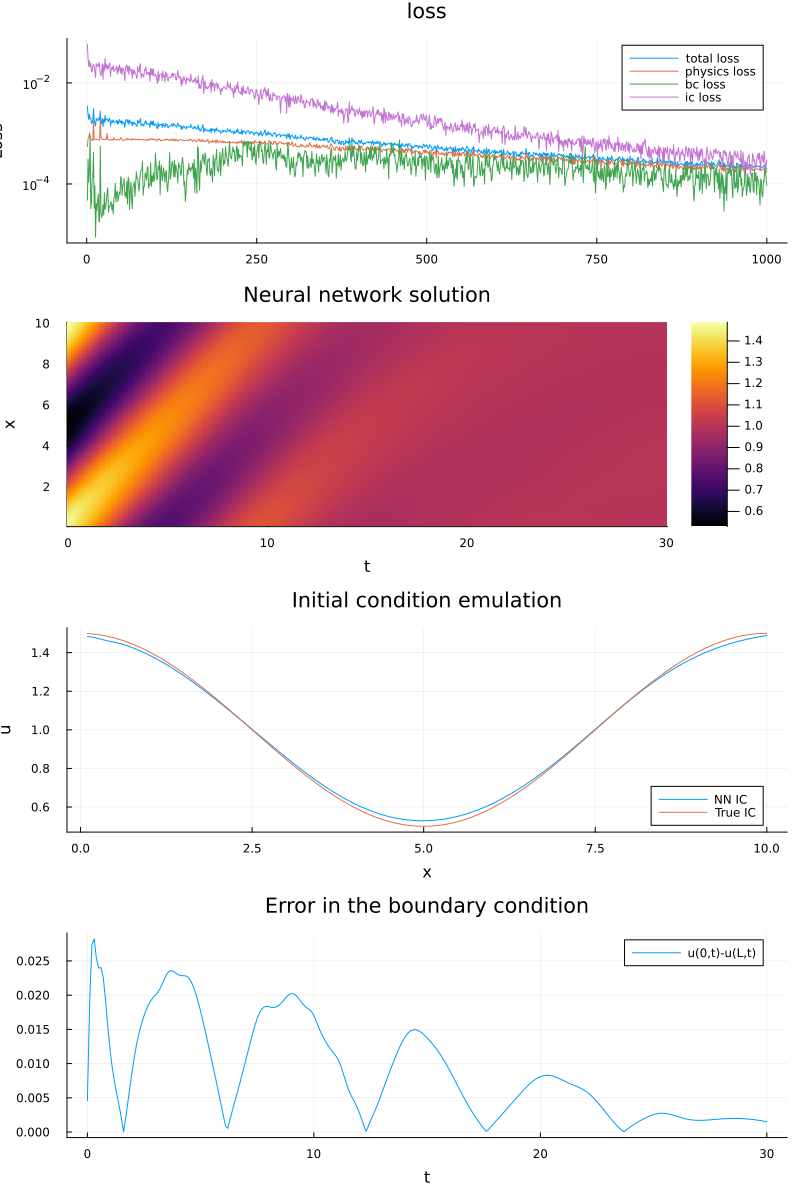

In [10]:
us = zeros(Float32, (length(x_grid), length(t_grid)))
for t_idx in 1:length(t_grid), x_idx in 1:length(x_grid)
    xt = reshape([x_grid[x_idx], t_grid[t_idx]], :, 1)
    us[x_idx, t_idx] = trained_model(xt)[1,1]
end

ic = us[:,1]
bc = abs.(us[1,:] .- us[end,:])

p0 = plot(losses.total_losses, yscale=:log10, ylabel="Loss", title="loss", label="total loss")
plot!(p0, losses.physics_losses, label="physics loss")
plot!(p0, losses.bc_losses, label="bc loss")
plot!(p0, losses.ic_losses, label="ic loss")
p1 = heatmap(t_grid, x_grid, us, xlabel="t", ylabel='x', title="Neural network solution")
p2 = plot(x_grid, ic, xlabel="x", ylabel="u", label="NN IC")
plot!(p2, x_grid, u0.(x_grid), label="True IC", title="Initial condition emulation")
p3 = plot(t_grid, bc, xlabel="t", ylabel="Δu", label="u(0,t)-u(L,t)", title="Error in the boundary condition")
plt = plot(p0, p1, p2, p3, layout=(4,1), size=(800,1200))
#savefig(plt, "pure_diffusion.png");

[ Info: Saved animation to /home/matspc/SSD/surrogate_flow/emulated_burgers.gif


Plots.AnimatedGif("/home/matspc/SSD/surrogate_flow/emulated_burgers.gif")
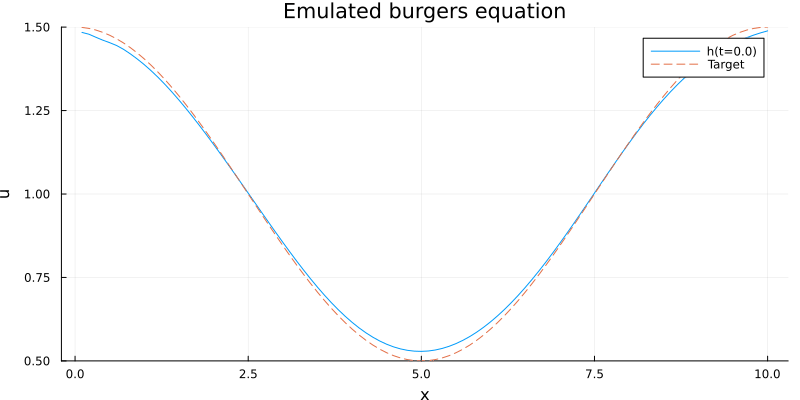

In [11]:
anim = @animate for i in 1:length(t_grid)
    p1 = plot(x_grid, us[:,i], label="h(t=$(round(t_grid[i],digits=2)))", xlabel='x', ylabel='u', ylim=(u_mean-u_amplitude, u_mean+u_amplitude))
    plot!(x_grid, u_target[i], label="Target", linestyle=:dash, legend=:topright)
    plot(p1, size=(800,400), title="Emulated burgers equation")
end
gif(anim, "emulated_burgers.gif", fps=15)